- Technological forecasting: 신제품, 혹은 신기술 등의 새로운 무엇인가가 등장했을 때, 시간에 따라 어떻게 사람들에게 널리 퍼지고 얼마나 많은사람들이 최종적으로 신제품을 구매하거나 신기술을 접하게 되는지 예측
- Bass model: This model has been widely influential in marketing and management science. In 2004 it was selected as one of the ten most frequently cited papers in the 50-year history of *Management Science*.

![Sales](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2Fo9U0S%2FbtqvRbZEoV0%2F9VqkvCVyGr0ACYc3dYy7fK%2Fimg.jpg)

# 1. Bass Model (1969)
- Single Generation
- Parameters (M, p, q)
   * M: maximum market potential (최대 잠재 시장)
   * p: Innovation coefficient (혁신계수). 신상품/신기술이 나온 직후 얼마나 팔릴까를 수치화한 계수
   * q: imitation coefficient (모방계수). 사람들이 얼마나 따라 구매하고 싶어 하는가를 수치화한 계수

In [1]:
from scipy.optimize import leastsq, curve_fit # 최적화 (least square minimization, curve fitting)
from sklearn.linear_model import LinearRegression # linear regression
import matplotlib.pyplot as plt # plot

import numpy as np
import pandas as pd

## Different shapes of curves depending on *p* and *q*
- Cumulative Distribution Function (CDF): 시점 t까지 누적 sales의 분포

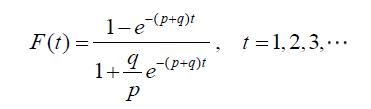

- Special cases
  - q=0: exponential distribution
  - p=0: logistic regression

- Probability Distribution Function (PDF): 시점 t일 때 sales의 분포

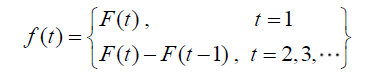

In [2]:
def penetration(m,p,q,t):
  """
  Esimate sales pdf & cdf based on Bass model
  """
  cofactor= np.exp(-(p+q) * t)
  Nt=m*(1-cofactor)/(1+(q/p)*cofactor) # CDF (cumulative sales)
  nt=m*(((p+q)**2/p)*cofactor)/(1+(q/p)*cofactor)**2 # PDF (incremental sales)
  return Nt, nt

### Simulation - Innovation coefficient (p)



In [3]:
m=10000
q=0.3
ps = [0.0001, 0.001, 0.005, 0.0075, 0.01]

In [4]:
t = np.linspace(0.0, 30.0, num=31)

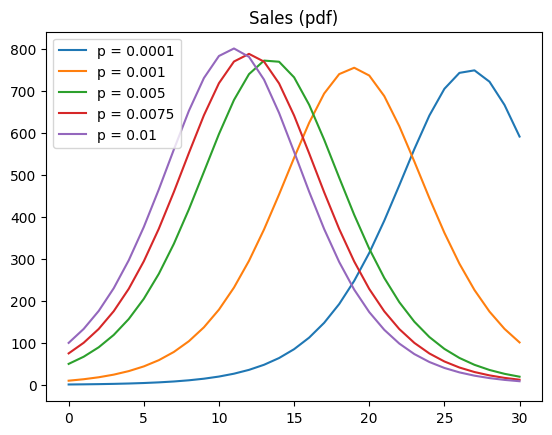

In [5]:
for p in ps:
  F, f = penetration(m, p, q, t)
  plt.plot(t, f, label=f'p = {p}')

plt.title('Sales (pdf)')
plt.legend()
plt.show()

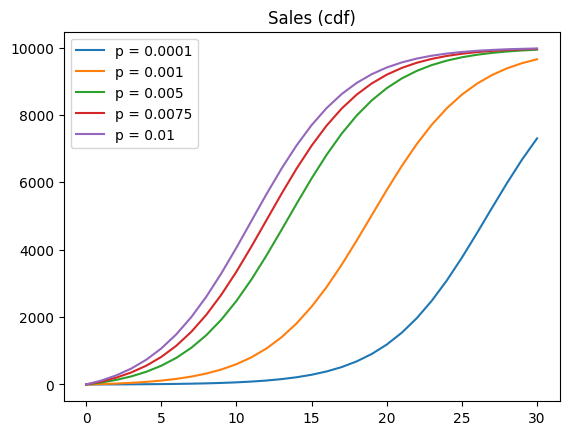

In [6]:
for p in ps:
  F, f = penetration(m, p, q, t)
  plt.plot(t, F, label=f'p = {p}')

plt.title('Sales (cdf)')
plt.legend()
plt.show()

### Simulation - Imitation coefficient (q)



In [7]:
m=10000
p=0.03
qs = [0.001, 0.01, 0.1, 0.3, 0.5]

In [8]:
t = np.linspace(0.0, 30.0, num=31)

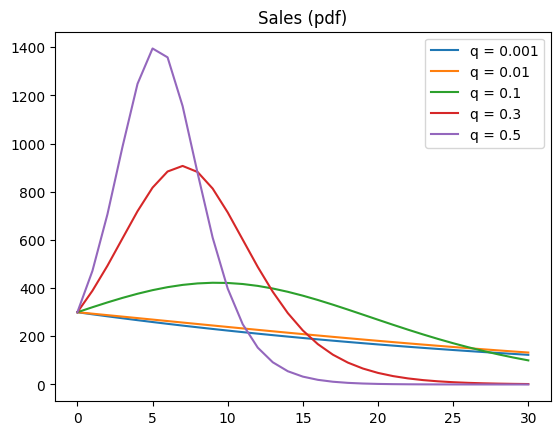

In [9]:
for q in qs:
  F, f = penetration(m, p, q, t)
  plt.plot(t, f, label=f'q = {q}')

plt.title('Sales (pdf)')
plt.legend()
plt.show()

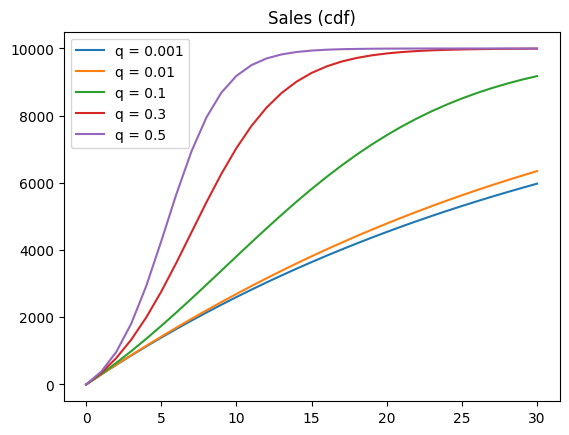

In [10]:
for q in qs:
  F, f = penetration(m, p, q, t)
  plt.plot(t, F, label=f'q = {q}')

plt.title('Sales (cdf)')
plt.legend()
plt.show()

### P and Q

  - *p*<*q*: periodic sales grow and then decline (a successful product has a periodic sales peak)
  - *q*<*p*: periodic sales decline from launch (no peak)
  

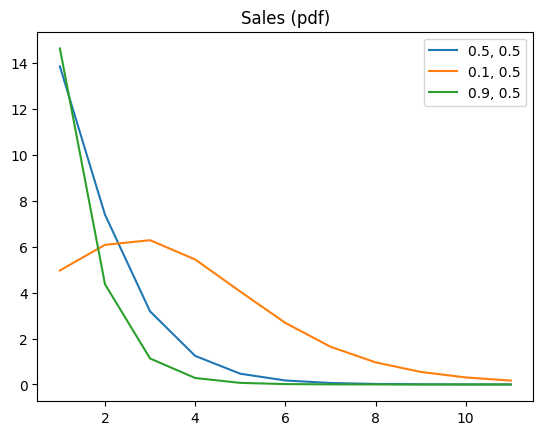

In [139]:
pqs = [(0.5, 0.5), (0.1, 0.5), (0.9, 0.5)]
for p_new, q in pqs:
  F, f = penetration(m, p_new, q, t)
  plt.plot(t, f, label=f'{p_new}, {q}')

plt.title('Sales (pdf)')
plt.legend()
plt.show()

## Estimation of parameters
- Unknown parameters

### Least square fitting

In [42]:
t = np.linspace(1.0, 20.0, num=20)

#Incr sales (n(t))
sales = np.array([0.1,3,5.2,7,5.25,4.9,3,2.4,1.9,1.3,0.8,0.6])

#Cumul sales(N(t)): cumulative number of adoptions/adopters
c_sales=np.cumsum(sales)

# inivital variables: unknown parameters to estimate
# M,p,q
vars = [35, 0.012, 0.4]

In [57]:
def estimation(vars,t):
  """
  Esimate sales pdf and cdf
  """
  M=vars[0]
  p=vars[1]
  q=vars[2]
  cofactor= np.exp(-(p+q) * t)

  # Inst base frac
  Ft=(1-cofactor)/(1+(q/p)*cofactor)
  #purchase time distribution
  ft=(((p+q)**2/p)*cofactor)/(1+(q/p)*cofactor)**2
  # salds cdf: cumulative sales prediction up to t
  Yt=M*Ft
  # sales pdf
  St=M*ft

  return Ft, ft, Yt, St

In [61]:
def sqerror(vars, sales, c_sales, esti, t):
  """
  Squared error function
  """
  Ft, ft, Nt, nt = estimation(vars, t)
  t_limit = len(sales)

  if esti=='n':
    return (nt[:t_limit]-sales)**2
  else:
    return (Nt[:t_limit]-c_sales)**2

In [63]:
_, _, Nt, nt = estimation(vars,t)
error=sqerror(vars,sales,c_sales,'N', t)
error

array([1.69850516e-01, 3.39452303e+00, 3.57131615e+01, 1.31971667e+02,
       2.17011964e+02, 2.90621995e+02, 2.85993516e+02, 2.48556446e+02,
       1.95038472e+02, 1.37204733e+02, 8.77232988e+01, 5.43095401e+01])

In [64]:
# non linear least square fitting
varfinal, success = leastsq(sqerror,vars,args=(sales,c_sales,'n',t))

In [65]:
# estimated coefficients
ma = varfinal[0]
pa = varfinal[1]
qa = varfinal[2]
print(ma,pa,qa)

32.938178799250394 0.021182482283558065 0.73410031929271


In [72]:
Ft, ft, Nt, nt = estimation(varfinal, t)

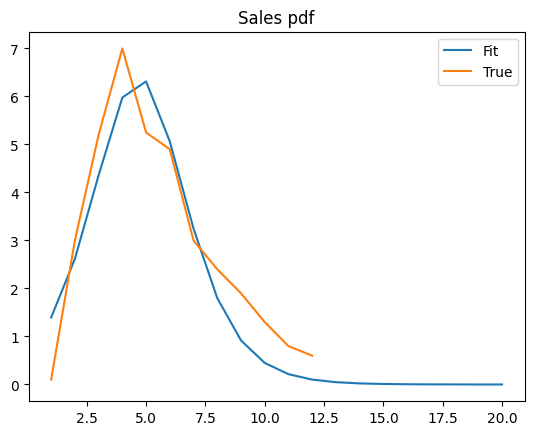

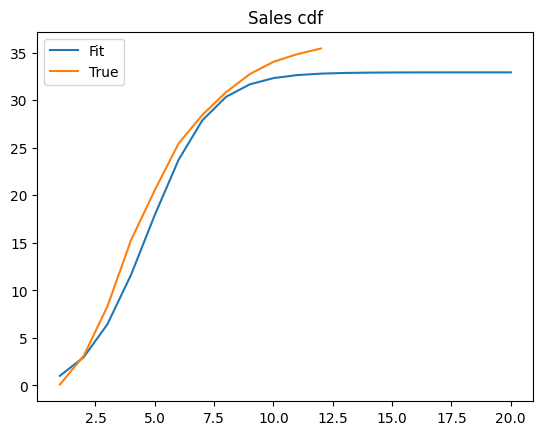

In [73]:
# sales plot (pdf)
plt.plot(t, nt, t[:len(sales)], sales)
plt.title('Sales pdf')
plt.legend(['Fit', 'True'])
plt.show()

# Cumulative sales (cdf)
plt.plot(t, Nt,t[:len(sales)], c_sales)
plt.title('Sales cdf')
plt.legend(['Fit', 'True'])
plt.show()

### Curve fit
- 이전 시점과 새로운 시점 간 누적 adoption의 차이를 기반으로 estimate
- 자세한 증명은 [다음](https://www.harshaash.com/Python/Diffusion%20on%20networks/)을 참고

In [97]:
import pandas as pd
data = pd.DataFrame({'week': [1,2,3,4,5,6,7,8,9,10,11,12], 'revenues': [0.1,3,5.2,7,5.25,4.9,3,2.4,1.9, 1.3, 0.8, 0.6]})
data['cum_sum'] = data['revenues'].cumsum()
data.head()

,week,revenues,cum_sum
0,1,0.10,0.10
1,2,3.00,3.10
2,3,5.20,8.30
3,4,7.00,15.30
4,5,5.25,20.55


In [100]:
from scipy.optimize import curve_fit

# Define the function to fit
def c_t(x, p, q, m):
    return (p + (q / m) * x) * (m - x)

# Provide the data to fit
x_data = data.cum_sum[:data.shape[0]-1]
y_data = data.revenues[1:data.shape[0]]

# Estimate the parameters using curve_fit
popt, pcov = curve_fit(c_t, x_data, y_data)

# Extract the estimated parameters
p = popt[0]
q = popt[1]
m = popt[2]

# Print the estimated parameters
print("Estimated parameters:")
print("m =", m)
print("p =", p)
print("q =", q)

Estimated parameters:
m = 35.22906716519078
p = 0.11467647680657252
q = 0.37950561732720767


- Future works
  - Temporal homogeneity
    - 혁신계수와 모방계수가 고정되어 있어, 제품이 출시된 이후부터 오랜 시간동안 소비자의 소비 행태가 변함이 없어야 한다는 가정 하에 성립된 분석 결과
    - 주로 모든 Bass 모델을 통한 수요 예측 분석은 정부정책, 기업의 분위기, 소비자의 소비 경향 등 시장에 영향을 주는 요소들이 이 유의하게 변화하지 않는다는 전제를 반드시 두고 시작
  - Spatial homogeneity
    - 가까운 공간(이웃)끼리 확산 속도의 차이 등을 반영하지 못함
    - Spatial diffusion을 반영하기 위한 다양한 연구들이 진행 중
      - Yan, Y., Tan, Z., Gao, X., Tang, S., & Chen, G. (2016, March). STH-Bass: A spatial-temporal heterogeneous bass model to predict single-tweet popularity. In International Conference on Database Systems for Advanced Applications (pp. 18-32). Cham: Springer International Publishing.
  - Consumer heterogeneity
    - 모든 개인이 동일한 p와 q를 가지는 경우를 가정하고 전체 확산을 연구
    - 소비자 별 특징에 따라 그룹 별로 확산 속도의 차이가 존재 (segment modeling)
    - 확산되는 소비자들의 네트워크/심리적 특성 등을 기반으로 heterogeneity를 고려한 연구들이 진행 중
      - [Network] Fibich, G., & Golan, A. (2023). Diffusion of new products with heterogeneous consumers. Mathematics of Operations Research, 48(1), 257-287.
      - [Segment] Abedi, V. S. (2019). Compartmental diffusion modeling: Describing customer heterogeneity & communication network to support decisions for new product introductions. Physica A: Statistical Mechanics and its Applications, 536, 120964.

# 2. Fisher & Pry model (1971)
- Mansfield model
- Single generation
- S-curve imitates Logistic function (cumulative sale)
- parameters
  * a: determines timing of the diffusion process
  * b: relative growth rate
  * y*: the number of potential adopters (limiting value; M)

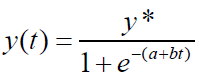

In [103]:
# year 데이터
t= np.linspace(1.0, 15.0, num=15)

# 가정: 초기 사용자=30명
a=-np.log(10000/30-1)
y_star=10000
b=2

vars=[y_star,a,b]

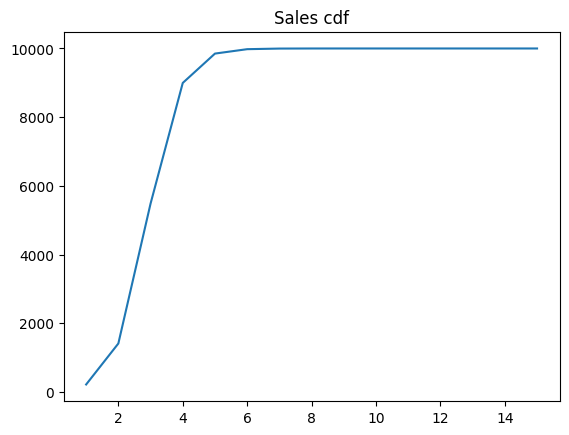

In [104]:
# sales plot (cdf)
yt=y_star/(1+np.exp(-(a+b*t)))
plt.plot(t,yt)
plt.title('Sales cdf')
plt.show()

In [ ]:
print(-a/b, 'is the period of differentiation of y(t) having the maximum')

2.903069240646864 is the period of differentiation of y(t) having the maximum


# 3. Norton & Bass Model (1987)
- Extension of Bass Model
- Multi-generation
  * ex) DRAM (4k, 16k, 64k, 256k)

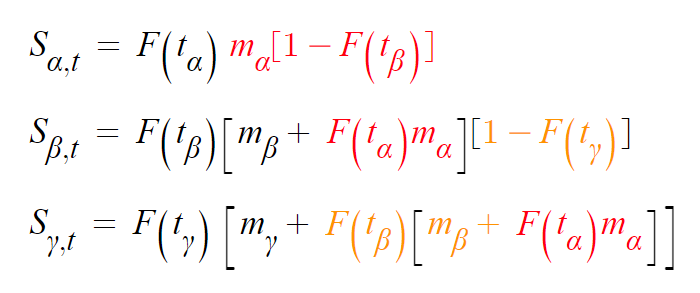

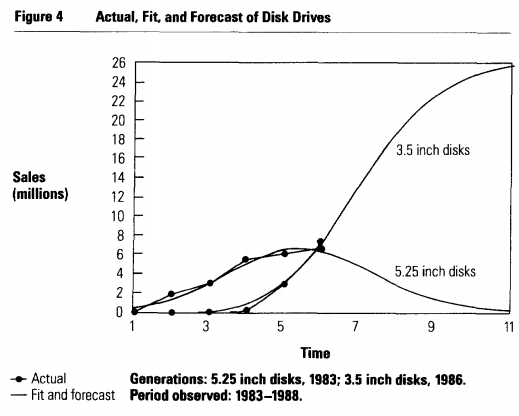

In [123]:
# year 데이터
t= np.linspace(1, 11, num=11)

# sales
s1=[0,20,30,61,63,70]
s2=[0,0,0,0,25,79]

# m1,m2,p,q
vars=[85,100,0.02,1.1]

In [106]:
def forecast(vars,t):
  """
  Esimate sales pdf and cdf
  """
  m1,m2 = vars[0],vars[1]
  p=vars[2]
  q=vars[3]

  # growth of the curve
  ### t: time since the introduction
  F1=[(1-np.exp(-(p+q) * tp))/(1+(q/p)*np.exp(-(p+q) * tp)) for tp in t]
  F2=np.zeros(4).tolist()+[(1-np.exp(-(p+q) * tp))/(1+(q/p)*np.exp(-(p+q) * tp)) for tp in t[0:-4].tolist()]
  #sales
  S1=[f1*m1*(1-f2) for f1,f2 in zip(F1,F2)]
  S2=[f2*(m2+f1*m1) for f1,f2 in zip(F1,F2)]

  return S1,S2

In [107]:
S1,S2=forecast(vars,t)

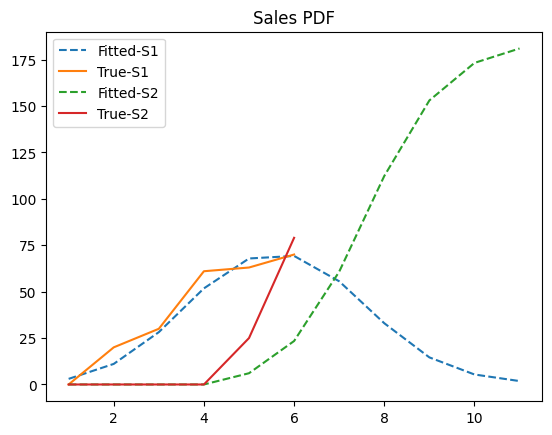

In [124]:
plt.plot(t, S1, '--', label='Fitted-S1')
plt.plot(t[:len(s1)], s1, '-', label='True-S1')
plt.plot(t, S2, '--', label='Fitted-S2')
plt.plot(t[:len(s2)], s2, '-', label='True-S2')

plt.title('Sales PDF')
plt.legend()

plt.show()

# References
- [수식 도출 과정](https://m.blog.naver.com/knowledge_retailer/221733372967)
- [Range of P & Q](https://en.wikipedia.org/wiki/Bass_diffusion_model)
- [Bass model Limitations and Extension](https://www.geeksforgeeks.org/bass-diffusion-model/)
- [Example - iPhone vs Galaxy forecasting](https://srdas.github.io/MLBook/productForecastingBassModel.html#iphone-sales-forecast)